In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d crowww/a-large-scale-fish-dataset



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 3.22G/3.24G [00:51<00:00, 61.8MB/s]
100% 3.24G/3.24G [00:51<00:00, 67.5MB/s]


In [ ]:
!unzip a-large-scale-fish-dataset.zip -d /content/data


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: /content/data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inf

In [ ]:
import os
import pandas as pd

In [ ]:
label = []
path = []
fish_dir = '/content/data/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label

In [ ]:
data

,path,label
0,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
1,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
2,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
3,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
4,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
...,...,...
8995,/content/data/Fish_Dataset/Fish_Dataset/Sea Ba...,Sea Bass
8996,/content/data/Fish_Dataset/Fish_Dataset/Sea Ba...,Sea Bass
8997,/content/data/Fish_Dataset/Fish_Dataset/Sea Ba...,Sea Bass
8998,/content/data/Fish_Dataset/Fish_Dataset/Sea Ba...,Sea Bass


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential


inception_v3 = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(299, 299, 3)))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in inception_v3.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras import layers

x = layers.Flatten()(inception_v3.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs=inception_v3.input, outputs=x)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = .001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall','F1Score'],
)

In [ ]:
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 135s 601ms/step - F1Score: 0.5033 - Precision: 0.6820 - Recall: 0.3428 - accuracy: 0.5077 - loss: 1.4325 - val_F1Score: 0.9641 - val_Precision: 0.9777 - val_Recall: 0.9438 - val_accuracy: 0.9639 - val_loss: 0.1683
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 109s 507ms/step - F1Score: 0.8965 - Precision: 0.9283 - Recall: 0.8594 - accuracy: 0.8974 - loss: 0.3228 - val_F1Score: 0.9777 - val_Precision: 0.9846 - val_Recall: 0.9743 - val_accuracy: 0.9785 - val_loss: 0.0820
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 131s 456ms/step - F1Score: 0.9393 - Precision: 0.9573 - Recall: 0.9160 - accuracy: 0.9396 - loss: 0.1979 - val_F1Score: 0.9881 - val_Precision: 0.9923 - val_Recall: 0.9840 - val_accuracy: 0.9882 - val_loss: 0.0545
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 156s 530ms/step - F1Score: 0.9628 - Precision: 0.9736 - Recall: 0.9497 - accuracy: 0.9629 - loss: 0.1293 - val_F1Score: 0.9923 - val_Precision: 0.9944 - val_Recall: 0.9917 - val_accuracy: 0.9924 - val_loss: 0.

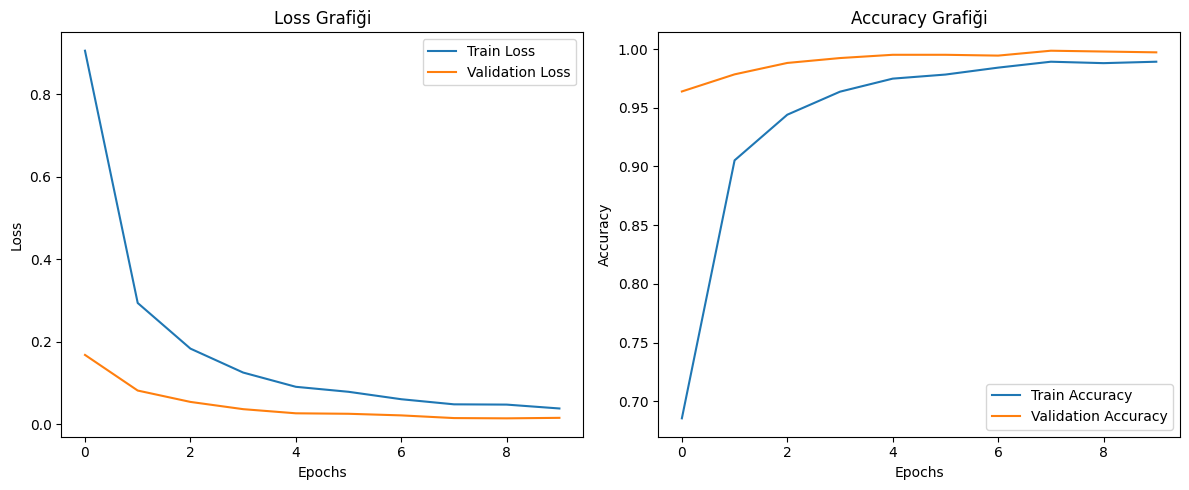

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Loss değeri için grafikleri çizdirelim.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy score grafikleri çizdirelim.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pred = model.predict(test_images)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 549ms/step


In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_images)

57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 434ms/step - F1Score: 0.9935 - Precision: 0.9954 - Recall: 0.9942 - accuracy: 0.9954 - loss: 0.0170


In [ ]:
import numpy as np

pred = model.predict(test_images)
pred_classes = np.argmax(pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step


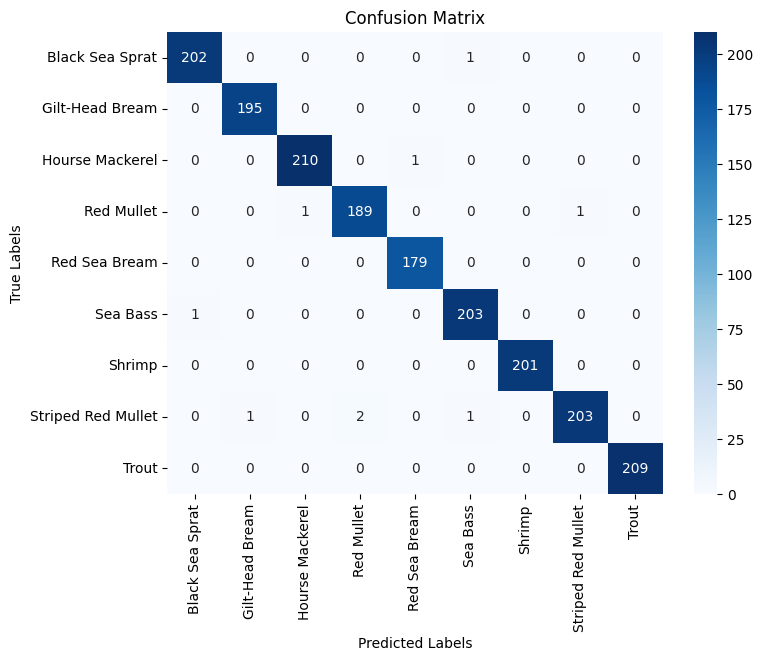

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_classes = test_images.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Sınıf etiketlerini alın
class_labels = list(test_images.class_indices.keys())

# Konfüzyon matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, pred_classes, target_names=class_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       203
   Gilt-Head Bream       0.99      1.00      1.00       195
   Hourse Mackerel       1.00      1.00      1.00       211
        Red Mullet       0.99      0.99      0.99       191
     Red Sea Bream       0.99      1.00      1.00       179
          Sea Bass       0.99      1.00      0.99       204
            Shrimp       1.00      1.00      1.00       201
Striped Red Mullet       1.00      0.98      0.99       207
             Trout       1.00      1.00      1.00       209

          accuracy                           0.99      1800
         macro avg       0.99      1.00      1.00      1800
      weighted avg       1.00      0.99      0.99      1800



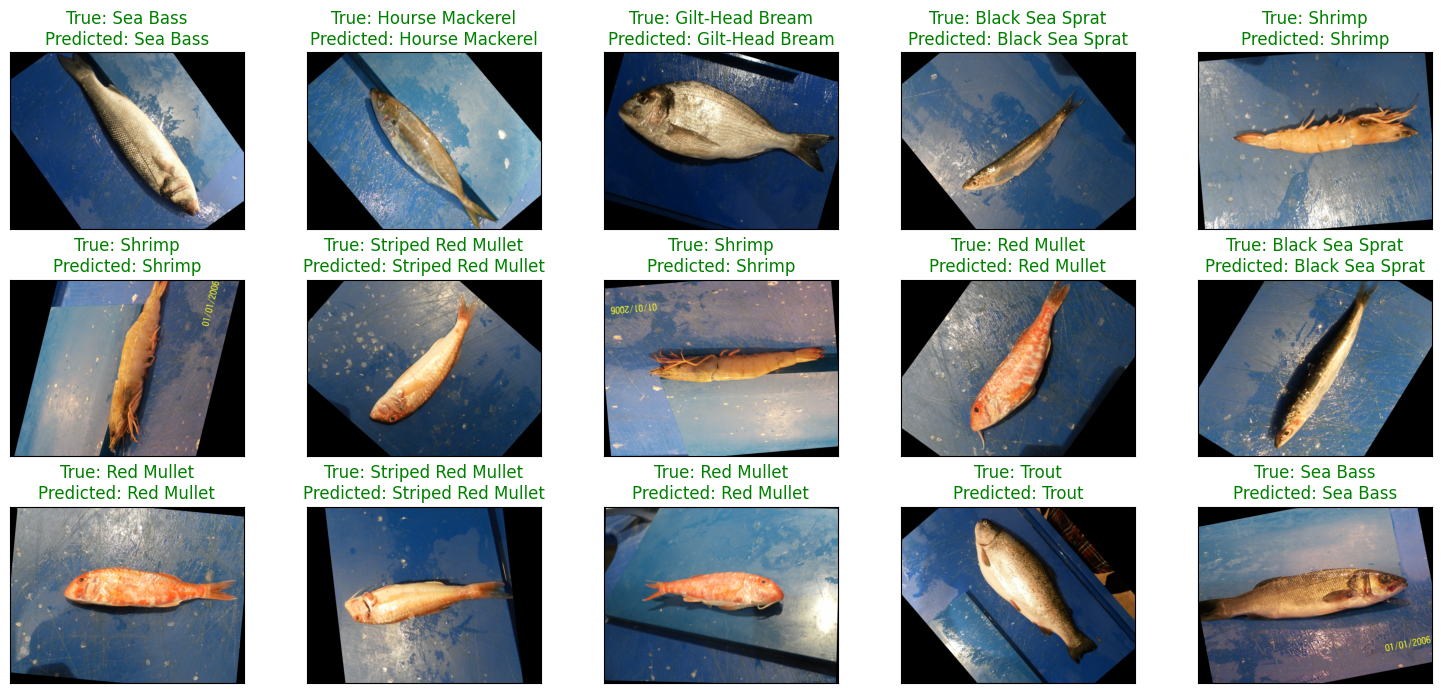

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_images.filepaths[i]))
    if test_images.labels[i] == pred_classes[i]:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f"True: {class_labels[test_images.labels[i]]}\nPredicted: {class_labels[pred_classes[i]]}", color = color)

plt.tight_layout()
plt.show()
